# DSE Course 3, Session 1: The Multilayer Perceptron

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

<br>

---

<br>

In this session we will introduce neural networks! We'll cover the over arching concepts used to talk about network architecture as well as their building blocks.

<br>

---

<br>

<a name='top'></a>

# Contents

* 1.0 [Preparing Environment and Importing Data](#x.0)
  * 1.0.1 [Import Packages](#x.0.1)
  * 1.0.2 [Load Dataset](#x.0.2)
* 1.1 [Neural Network Architectures](#x.1)
  * 1.1.1 [Input, Output, and Hidden Layers](#x.1.1)
  * 1.1.2 [Feed Forward](#x.1.2)
  * 1.1.3 [Recurrent](#x.1.3)
  * 1.1.4 [Convolutional](#x.1.4)
* 1.2 [Neural Network Building Blocks](#x.2)
  * 1.2.1 [Assigning Blame](#x.2.1)
  * 1.2.2 [Chain Rule](#x.2.2)
  * 1.2.3 [Back-Propagation](#x.2.3)
  * 1.2.4 [Maximum Likelihood Estimation](#x.2.4)
    * 1.2.4.1 [Linear Regression as Maximum Likelihood](#x.2.4.1)
  * 1.2.5 [Activation Functions](#x.2.5)
* 1.3 [Enrichment: Program Your Own Neural Network](#x.3)
  

<br>

---

<a name='x.0'></a>

## 1.0 Preparing Environment and Importing Data

[back to top](#top)

In [1]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 22.3MB 1.3MB/s 


<a name='x.0.1'></a>

### 1.0.1 Import Packages

[back to top](#top)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from copy import copy
sns.set()

<a name='x.0.1'></a>

### 1.0.2 Load Dataset

[back to top](#top)

In [ ]:
# Code Cell for Exercise 4.2.4
wine = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
      "ds_for_engineers/main/data/wine_quality/winequalityN.csv")
wine.dropna(inplace=True)
wine['quality_label'] = wine['quality'].apply(lambda x: 'low' if x <=5 else
                                              'med' if x <= 7 else 'high')

wine['type_encoding'] = wine['type'].map({'red': 0, 'white': 1})
wine['quality_encoding'] = wine['quality_label'].map({'low':0, 
                                                      'med': 1, 'high': 2})
y_ql = wine['quality_encoding']
wine.columns = wine.columns.str.replace(' ', '_')

features = list(wine.columns[1:-1].values)
features.remove('quality_label')
features.remove('quality')

# since we use density as a target in some of the examples I'm
# going to make a feature list that doesn't include density
non_density = copy(features)
non_density.remove('density')

In [57]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.pipeline import make_pipeline
set_config(display='diagram')

wine = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
      "ds_for_engineers/main/data/wine_quality/winequalityN.csv")

X = wine.copy()
# Remove target
y = X.pop('quality')

X_train, X_test, y_train, y_test = train_test_split(X, y)

num_proc = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

cat_proc = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore'))

preprocessor = make_column_transformer((num_proc,
                                make_column_selector(dtype_include=np.number)),
                                       (cat_proc,
                                make_column_selector(dtype_include=object)))

X_train_std = preprocessor.fit_transform(X_train)
X_test_std = preprocessor.transform(X_test)
y_train_std = np.log(y_train)

preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7496a06d50>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7496a06d90>)])

<a name='x.1'></a>

## 1.2 Neural Network Building Blocks

[back to top](#top)

<a name='x.1.1'></a>

### 1.1.1 The Perceptron

[back to top](#top)

The simplest unit of a neural network is the perceptron. Given an input vector $x$ and an output vector $y$, we can illustrate this like so:

<p align=center>
<img src="https://i.imgur.com/mfOlDR6.png"></img>
</p>

where $w$ is a weight applied to $x$ and $b$ is an unweighted term that we call the <i>bias</i>. We include a bias so that the perceptron is not entirely dependent on the input data. A neural network _learns_ by updating $w$ and $b$ so that it can accurately model $x$ to $y$. When we write out the perceptron mathematically we get the following:

$$ y = xw+b $$

which should look familiar! This is our equation for a linear function. In fact, we will see that a neural network is essentially many instances of linear regression along side, and being fed into, one another. 

Often, we will have not an input feature vector $x$ but an input feature matrix, $X$. We can update our schematic for a perceptron to account for this:

<p align=center>
<img src="https://i.imgur.com/vyXSnlZ.png"></img>
</p>

We can write the mathematical formula for this neuron as follows:

$$ y =  x_2 w_2 + x_1 w_1 + x_0 w_0 + b $$

In tensorflow/keras we can define this perceptron:

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

# Create a network with 1 linear unit
model = keras.Sequential([
    layers.Dense(units=1, input_shape=[3])
])

In order to build this single perceptron with keras, I had to use some additional language here: layers, dense, sequential. We'll explain what these are referring to in a moment. What I want to draw your attention to now, however, is that we tell `layers.Dense` that we want _1 unit_, the single perceptron, and `input_shape=[3]`, the number of features. Notice that `b` is automatically included without having it as a parameter. Just as we always have a y intercept in a linear model. 

After we introduce the other aspects of the neural network architecture, we will train a single perceptron model and compare it with a linear model, we will see that they are functionally no different.

### 1.1.2 Exercise: Single Perceptron

define a single perceptron that could be used to predict wine density from acidity. 


Inpsect the weights.

Use the untrained model to predict y and plot this against true y

In [48]:
# Code cell for exercise 1.2.2
model = keras.Sequential([
    layers.Dense(units=1, input_shape=[1])
])
model.weights

[<tf.Variable 'dense_37/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-1.1831069]], dtype=float32)>,
 <tf.Variable 'dense_37/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

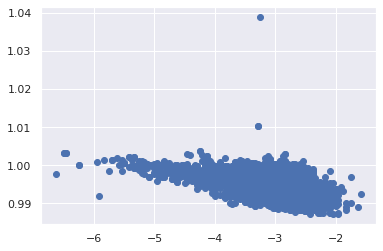

In [16]:
y_pred = model.predict(wine['fixed acidity'])
plt.plot(y_pred, wine['density'], ls='', marker='o')

<a name='x.2'></a>

## 1.2 Neural Network Architectures

[back to top](#top)



<a name='x.2.1'></a>

###1.2.1 Neural Network Layers

[back to top](#top)

Now that we have the idea of the most basic building block of a neural network, we will start to discuss the larger architecture. The reason we focused on the lowest building block, is that neural networks are _modular_. They are made up of instances of these perceptrons or neurons. neurons in parallel make up a _layer_

<p align=center>
<img src="https://i.imgur.com/2MA4iMV.png"></img>
<p>

These layers feed into one another. When each node of a preceding layer is connected to every node of a following layer, we say they are _fully connected_ and the receiving layer is _a dense layer_. In a moment we will talk about input, output and hidden layers, for neural networks with three or more layers.

<a name='x.2.2'></a>

### 1.2.2 The Activation Function

[back to top](#top)

It turns out that stringing together a bunch of linear functions, will still result in overall linear relationships. We need a way to break out of this. A neat trick is introduced at the output of each neuron. The output passes through an _activation function_. There are a handful of different activation functions used in practice, the most common is known as the _rectifier_ function:

$$ max(f(x), 0) $$

and the resulting node can be schematically drawn like this:

<p align=center>
<img src="https://i.imgur.com/eFry7Yu.png"></img>
</p>

with the inset of the summation node indicating that at a minimum the resultant y value is 0.

<a name='x.2.3'></a>

### 1.2.3 Stacking Layers

[back to top](#top)

When we stack many layers together, we create what are traditionally regarded as neural networks. the first and last layers are called the _input_ and _output_ layers, while the inbetween layers are referred to as _hidden_ layers, since their outputs are not directly seen. Tradditionally, a neural network with three or more hidden layers is referred to as a _deep_ neural network.

<p align=center>
<img src="https://i.imgur.com/Y5iwFQZ.png"></img
</p>

Notice that in this schematic, the last node does not have an activation function. This is typical of a regression task. In a classification task, we might require an activation function here.

<a name='x.2.2'></a>

### 1.2.2 Building Sequential Neural Networks

[back to top](#top)

Now that we have the essential components of a neural network architecture, we can enter into the domain of overall naming conventions for architecure types. The classic neural network architecture is a _feed forward_ neural network, where every preceding layer feeds into the next layer. We will practice building that with keras.

### 1.2.5 Exercise: Building Sequential Layers

In the cell bellow, use keras to build a 3-layer network with `activation='relu'` and 512 units for the hidden layer. 

In [61]:
# Cell for exercise 1.1.5

model = keras.Sequential([
    # the hidden ReLU layers
    layers.Dense(units=512, activation='relu', input_shape=[1]),
    layers.Dense(units=512, activation='relu'),
    layers.Dense(units=512, activation='relu'),
    # the linear output layer 
    layers.Dense(units=1),
])

### 1.2.6 Exercise: Other Activation Functions

There are other activation functions we can use after the summation in a neural node. Use the code below to plot and inspect them!

Pick one and do a quick google search on what that activation function's best use case is.

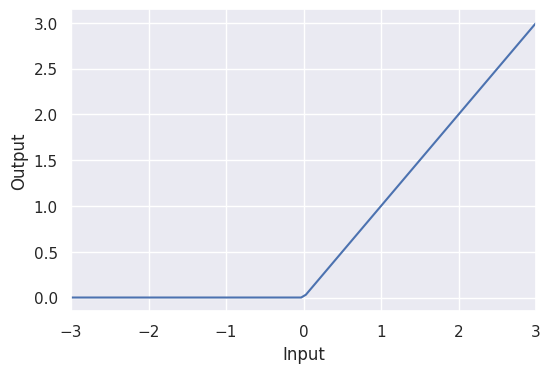

In [53]:
import tensorflow as tf

# YOUR CODE HERE: Change 'relu' to 'elu', 'selu', 'swish'... or something else
activation_layer = layers.Activation('relu')

x = tf.linspace(-3.0, 3.0, 100)
y = activation_layer(x) # once created, a layer is callable just like a function

plt.figure(dpi=100)
plt.plot(x, y)
plt.xlim(-3, 3)
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

<a name='x.3'></a>

## 1.3 Neural Network Training

[back to top](#top)

We've defined neural network architectures, now how do we train them? There are two main concepts here: the _loss function_ which we've encountered before, and the _optimizer_ the means by which we improve the loss function

<a name='x.3.1'></a>

### 1.3.1 The Loss Function

[back to top](#top)

In previous sessions, we've envountered MSE:

$$ MSE = \frac{1}{N}\sum{(y-\hat{y})^2}$$

<p align=center>
<img src="https://cdn.corporatefinanceinstitute.com/assets/Sum-of-Squares-1024x712.png" width=400></img>
</p>

Another common loss for neural networks is the mean absolute error (MAE):

$$ MAE = \frac{1}{N}\sum{|y-\hat{y}|}$$

<p align=center>
<img src="https://cdn-media-1.freecodecamp.org/images/MNskFmGPKuQfMLdmpkT-X7-8w2cJXulP3683" width=400></img>
</p>

In anycase, the loss function describes the difference between the actual and predicted output of the model. The important thing to note, is that the weights in the neural network are systematically updated according to this loss function, they do this via an optimization algorithm.

<a name='x.3.2'></a>

### 1.3.2 The Optimizer

[back to top](#top)

In order to update the neural network weights to improve the loss function, we require an algorithm. Virtually all available algorithms for this purpose fall within the family of _stochastic gradient descent_. This works essentially in these iterative steps:

1. a subsample of the input data is passed through the network 
2. a loss is computed
2. the weights are adjusted in a direction to improve the loss

> The key here is in step 3. The brilliance of neural networks, is that the loss function is differentiable with respect to the weights in the network, and so the change in loss can be ascribed to certain weight changes. We refer to this as _assigning blame_ in the network, and it works through the mathematical _chain rule_ of differentiation. We won't go into great detail here, other than to make a nod to it, and that this algorithm (step 3) is referred to as _back propagation_. 

The three step process is repeated until a stop criteria is reached, the simplest being the loss stops improving above some threshold or a desired loss is achieved. 

<p align=center>
<img src="https://i.imgur.com/rFI1tIk.gif"></img>
</p>

In the above animation, the black line represents the output of the model, the red dots make up a _minibatch_ or simple a _batch_ while the opaque red dots represent the whole training dataset. Exposing the model to an entire round of the training data is referred to as an _epoch_. The training loss improves with additional rounds of trianing (middle panel) and the weights are adjusted to update the model (right panel).


### 1.3.3 Batches and Epochs

An epoch is the number of times the model will see the entire training set

A batch is the number of training samples the model will run before calculating a total error and updating its internal parameters. 

Variability of batch (from 1 sample all the way to the entire training set size) leads to different categorizations of the optimizer algorithm:

* Batch Gradient Descent. Batch Size = Size of Training Set
* Stochastic Gradient Descent. Batch Size = 1
* Mini-Batch Gradient Descent. 1 < Batch Size < Size of Training Set

We will visit additional details about batch and epochs in the next session when we discuss model evaluation.

<a name='x.3.3'></a>

### 1.3.4 Learning Rate

[back to top](#top)

notice how in the above animation the model makes progressive steps toward a global optimum. The size of these steps is determined by the _learning rate_. You can think of it as the amount of improvement to make in the direction of steepest descent (the derivative of the loss function in regards to the changes in weights). Sometimes a large step size can result in stepping over crevices in the solution surface and getting stuck, while too small of step sizes can lead to a slow algorithm. Often the optimum learning rate is not obvious, luckily there are some optimizers that are self-calibrating in this regard. _Adam_ is one such optimizer available to us in keras. 

In [54]:
# we can compile the model like so
model.compile(
    optimizer="adam",
    loss="mae",
)

### 1.3.5 Exercise: Train your first Neural Networks

[back to top](#top)

In [76]:
X = wine.copy()
# Remove target
y = X.pop('quality')

X_train, X_test, y_train, y_test = train_test_split(X, y)

num_proc = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

cat_proc = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore'))

preprocessor = make_column_transformer((num_proc,
                                make_column_selector(dtype_include=np.number)),
                                       (cat_proc,
                                make_column_selector(dtype_include=object)))

X_train_std = preprocessor.fit_transform(X_train)
X_test_std = preprocessor.transform(X_test)
y_train_std = np.log(y_train)
y_test_std = np.log(y_test)

preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7495a56950>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f749727a7d0>)])

In [62]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[X_train_std.shape[1]]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

In [63]:
model.compile(
    optimizer='adam',
    loss='mse',
)

In [71]:
history = model.fit(
    X_train_std, y_train_std,
    # validation_data=(X_test_std, y_test),
    batch_size=256,
    epochs=10,
)

Epoch 1/10
20/20 [==============================] - 1s 25ms/step - loss: 2.5235
Epoch 2/10
20/20 [==============================] - 1s 28ms/step - loss: 0.2435
Epoch 3/10
20/20 [==============================] - 0s 25ms/step - loss: 0.0840
Epoch 4/10
20/20 [==============================] - 1s 26ms/step - loss: 0.0633
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.0510
Epoch 6/10
20/20 [==============================] - 1s 25ms/step - loss: 0.0424
Epoch 7/10
20/20 [==============================] - 1s 26ms/step - loss: 0.0351
Epoch 8/10
20/20 [==============================] - 1s 26ms/step - loss: 0.0290
Epoch 9/10
20/20 [==============================] - 0s 23ms/step - loss: 0.0245
Epoch 10/10
20/20 [==============================] - 1s 25ms/step - loss: 0.0213


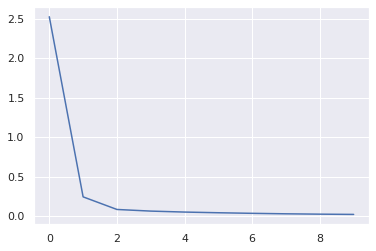

In [72]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df['loss'].plot();

In [75]:
history_df.tail()

,loss
5,0.042366
6,0.035081
7,0.028997
8,0.024518
9,0.021288


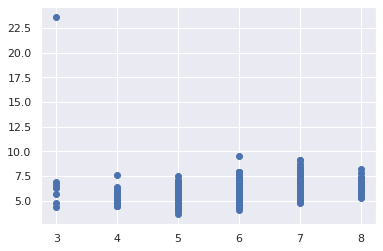

In [74]:
y_pred = model.predict(X_test_std)
plt.plot(np.exp(y_test_std), np.exp(y_pred), ls='', marker='o')

#### 1.3.5.1 Improve loss by varying nodes and hidden layers

In [83]:
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 1024)              14336     
_________________________________________________________________
dense_55 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_56 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 513       
Total params: 1,589,249
Trainable params: 1,589,249
Non-trainable params: 0
_________________________________________________________________


In [93]:
X_train_std.shape

(4872, 13)

In [94]:
1049600/1024

1025.0

In [98]:
(13+1)*1024 + (1024 + 1) * 1024 + (1024 + 1 )* 512 + (512 + 1) * 1

1589249

In [90]:
print([i.shape for i in model.trainable_weights])

[TensorShape([13, 1024]),
 TensorShape([1024]),
 TensorShape([1024, 1024]),
 TensorShape([1024]),
 TensorShape([1024, 512]),
 TensorShape([512]),
 TensorShape([512, 1]),
 TensorShape([1])]

In [80]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(512*2, activation='relu', input_shape=[X_train_std.shape[1]]),
    layers.Dense(512*2, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mse',
)

history = model.fit(
    X_train_std, y_train_std,
    # validation_data=(X_test_std, y_test),
    batch_size=256,
    epochs=20,
    verbose=1
)

Epoch 1/20
20/20 [==============================] - 2s 64ms/step - loss: 0.5050
Epoch 2/20
20/20 [==============================] - 1s 66ms/step - loss: 0.1002
Epoch 3/20
20/20 [==============================] - 1s 63ms/step - loss: 0.0511
Epoch 4/20
20/20 [==============================] - 1s 65ms/step - loss: 0.0303
Epoch 5/20
20/20 [==============================] - 1s 65ms/step - loss: 0.0220
Epoch 6/20
20/20 [==============================] - 1s 64ms/step - loss: 0.0176
Epoch 7/20
20/20 [==============================] - 1s 67ms/step - loss: 0.0166
Epoch 8/20
20/20 [==============================] - 1s 64ms/step - loss: 0.0157
Epoch 9/20
20/20 [==============================] - 1s 64ms/step - loss: 0.0151
Epoch 10/20
20/20 [==============================] - 1s 65ms/step - loss: 0.0141
Epoch 11/20
20/20 [==============================] - 1s 63ms/step - loss: 0.0138
Epoch 12/20
20/20 [==============================] - 1s 65ms/step - loss: 0.0143
Epoch 13/20
20/20 [==================

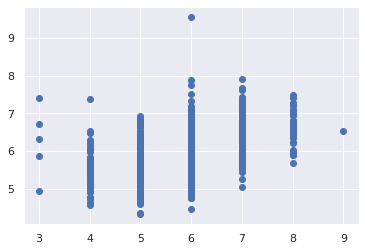

In [81]:
y_pred = model.predict(X_test_std)
plt.plot(np.exp(y_test_std), np.exp(y_pred), ls='', marker='o')

#### 1.3.5.2 Learning Curves

1. Vary the number of nodes vs train/test loss (5 variations, no more than 20 epochs)

2. Vary the number of layers vs train/test loss (5 variations, no more than 20 epochs)

In [103]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[X_train_std.shape[1]]),
    layers.Dense(512*2, activation='relu'),
    layers.Dense(512*4, activation='relu'),
    layers.Dense(512*2, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mse',
)

history = model.fit(
    X_train_std, y_train_std,
    # validation_data=(X_test_std, y_test),
    batch_size=256,
    epochs=40,
    verbose=1
)

Epoch 1/40
20/20 [==============================] - 4s 188ms/step - loss: 0.3334
Epoch 2/40
20/20 [==============================] - 4s 187ms/step - loss: 0.0394
Epoch 3/40
20/20 [==============================] - 4s 187ms/step - loss: 0.0214
Epoch 4/40
20/20 [==============================] - 4s 186ms/step - loss: 0.0189
Epoch 5/40
20/20 [==============================] - 4s 188ms/step - loss: 0.0219
Epoch 6/40
20/20 [==============================] - 4s 187ms/step - loss: 0.0193
Epoch 7/40
20/20 [==============================] - 4s 186ms/step - loss: 0.0150
Epoch 8/40
20/20 [==============================] - 4s 187ms/step - loss: 0.0154
Epoch 9/40
20/20 [==============================] - 4s 187ms/step - loss: 0.0275
Epoch 10/40
20/20 [==============================] - 4s 188ms/step - loss: 0.0176
Epoch 11/40
20/20 [==============================] - 4s 188ms/step - loss: 0.0175
Epoch 12/40
20/20 [==============================] - 4s 187ms/step - loss: 0.0130
Epoch 13/40
20/20 [======

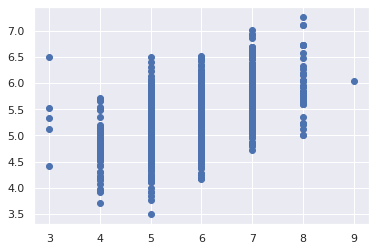

In [104]:
y_pred = model.predict(X_test_std)
plt.plot(np.exp(y_test_std), np.exp(y_pred), ls='', marker='o')

When we look at our historical loss do we notice that sometimes before the last epoch we actually hit a minimum? We'll discuss how to deal with this in the next session!

> what else do we notice about the relationship between layers and epochs?

In [107]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[X_train_std.shape[1]]),
    layers.Dense(512*2, activation='relu'),
    layers.Dense(512*4, activation='relu'),
    layers.Dense(512*2, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mse',
)

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train_std, y_train_std,
    validation_data=(X_test_std, y_test_std),
    batch_size=256,
    epochs=1000,
    verbose=1,
    callbacks=[early_stopping],
)

Epoch 1/1000
20/20 [==============================] - 5s 211ms/step - loss: 0.3201 - val_loss: 0.0864
Epoch 2/1000
20/20 [==============================] - 4s 203ms/step - loss: 0.0468 - val_loss: 0.0273
Epoch 3/1000
20/20 [==============================] - 4s 204ms/step - loss: 0.0241 - val_loss: 0.0203
Epoch 4/1000
20/20 [==============================] - 4s 203ms/step - loss: 0.0178 - val_loss: 0.0356
Epoch 5/1000
20/20 [==============================] - 4s 207ms/step - loss: 0.0216 - val_loss: 0.0303
Epoch 6/1000
20/20 [==============================] - 4s 206ms/step - loss: 0.0195 - val_loss: 0.0173
Epoch 7/1000
20/20 [==============================] - 4s 205ms/step - loss: 0.0161 - val_loss: 0.0178
Epoch 8/1000
20/20 [==============================] - 4s 205ms/step - loss: 0.0149 - val_loss: 0.0164
Epoch 9/1000
20/20 [==============================] - 4s 203ms/step - loss: 0.0156 - val_loss: 0.0187
Epoch 10/1000
20/20 [==============================] - 4s 205ms/step - loss: 0.015